In [1]:
from collections import Counter
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import importlib
import random

from Project.utils.objects import youtube
from Project.utils.storage import youtube_db as db


importlib.reload(db)
importlib.reload(youtube)

<module 'Project.utils.objects.youtube' from 'C:\\Users\\Filippo Corti\\Documents\\GitHub\\SocialMediaMining\\Project\\utils\\objects\\youtube.py'>

In [2]:
trump_podcasts = [
    "xrFdHO7FH8w",
    "blqIZGXWUpU",
    "s11uIW7wi-E",
    "vC5cHjcgt5g",
    "G80iLTctFuY",
    "qCbfTN-caFI",
    "Ry1IjOft95c",
    "S7BTdUaNQM8",
    "1SsmPh8gCxU",
    "-dmwG54QsKc",
    "nwQil7tcImI",
    "G9lXnwuZ2qs",
    "hBMoPUAeLnY"
]

harris_podcasts = [
    "_KCRsjPCiCI",
    "bzThwqnQJDY",
    "7L4sts7I3xI",
    "pNbwMrBMGgE",
    "Vu5yD3fu6A8",
]

youtube_db = db.SQLiteYoutubeSaver()

In [3]:
Youtube_Graph = youtube_db.extract_network()

# Add podcast_guest attribute
for node, data in Youtube_Graph.nodes(data=True):
    video_id = data.get('most_commented_video_id')
    if video_id in trump_podcasts:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Trump'
    else:
        Youtube_Graph.nodes[node]['podcast_guest'] = 'Harris'

#nx.write_gexf(Youtube_Graph, "youtube.gexf")

# Youtube_Graph = nx.read_gexf("data/youtube.gexf")

In [4]:
def gini_coeff(x):
    x = np.sort(np.array(x))
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def analyze_graph(G, color):
    print(f"{G.order()} Nodes and {G.size()} Edges")
    print(f"Density is {nx.density(G)}")

    degree = dict(G.degree())
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())
    degree_values = list(degree.values())
    in_degree_values = list(in_degree.values())
    out_degree_values = list(out_degree.values())

    # Calculate Lorenz Curve for the Distribution of Posts between Users
    posts_count_dict = np.sort([
        node['comments_count']
        for node_id, node in G.nodes(data=True)
    ])
    posts_count_cdf = np.cumsum(posts_count_dict) / sum(posts_count_dict)
    lam = nx.density(G) * (G.order() - 1)
    poisson_posts_count = np.sort(np.random.poisson(lam=lam, size=len(posts_count_dict)))
    poisson_posts_count_cdf = np.cumsum(poisson_posts_count) / sum(poisson_posts_count)


    count, bins = np.histogram(
        in_degree_values,
        bins=np.arange(0, max(in_degree_values) + 2)
    )
    pdf = count / G.order()
    ccdf = 1.0 - np.cumsum(pdf)

    ccdf[-1] = 0.0 # Fixes floating point error

    print(f"Nodes with in degree zero: {len([x for x in in_degree_values if x == 0])}")

    # Compute connected component sizes
    cc = list(nx.weakly_connected_components(G))
    component_sizes = sorted([len(c) for c in cc], reverse=True)
    components_by_size = Counter(component_sizes)

    # Print stats
    print(f"Min Degree: {min(degree_values)}")
    print(f"Max Degree: {max(degree_values)}")
    print(f"Average Degree: {np.mean(degree_values):.2f}")
    print(f"Average In-Degree: {np.mean(in_degree_values):.2f}")
    print(f"Average Out-Degree: {np.mean(out_degree_values):.2f}")

    print(f"There are {len(cc)} Connected Components:")
    for component in cc[:min(3, len(cc))]:
        print(f"\tConnected Component of size: {len(component)} ({len(component)/G.order():.2%})")
    print("\t...")

    top_in = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by In-Degree:")
    for node, deg in top_in:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: In-Degree = {deg}")

    top_out = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Out-Degree:")
    for node, deg in top_out:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Out-Degree = {deg}")

    # Degree Centrality
    deg_centrality = nx.degree_centrality(G)
    top_deg_centrality = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print("Top 3 Nodes by Degree Centrality:")
    for node, centrality in top_deg_centrality:
        attrs = G.nodes(data=True)[node]
        print(f"\tNode {attrs['username']} {attrs['url']}: Degree Centrality = {centrality:.4f}")


    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-1], pdf, marker='o', linestyle='--', label="Degree PDF", color=color)
    #plt.xscale("log")
    #plt.yscale("log")
    plt.title("In-Degree PDF")
    plt.xlabel("Degree")
    plt.ylabel("PDF - P(X=x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(bins[:-2], ccdf[:-1], marker='o', linestyle='--', label="Degree CCDF", color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("In-Degree CCDF")
    plt.xlabel("Degree")
    plt.ylabel("CCDF - P(X>x)")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.scatter(np.arange(len(posts_count_cdf)) / (len(posts_count_dict) - 1), posts_count_cdf, marker='o', linestyle='--', label="Network", color=color)
    plt.scatter(np.arange(len(poisson_posts_count_cdf)) / (len(poisson_posts_count) - 1), poisson_posts_count_cdf, marker='o', linestyle='--', label="Erdos-Renyi Random Network", color="gray")
    plt.plot([0, 1], [0, 1], 'k--', label="Equality Line")
    plt.title("Lorenz Curve of Posts per User")
    plt.xlabel("Cum. % of Users")
    plt.ylabel("Cum. % of Posts")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Gini Coefficient: {gini_coeff(posts_count_dict):.5f}")

    plt.figure(figsize=(7, 4))
    plt.scatter(list(components_by_size.keys()), list(components_by_size.values()), color=color)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Weakly Connected Components")
    plt.xlabel("Component Size")
    plt.ylabel("# of Components")
    plt.grid()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(list(deg_centrality.values()), bins=50, log=True, color=color, alpha=0.7)
    plt.title("Distribuzione Degree Centrality")
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


58300 Nodes and 97531 Edges
Density is 2.8695448497788227e-05
Nodes with in degree zero: 42179
Min Degree: 1
Max Degree: 691
Average Degree: 3.35
Average In-Degree: 1.67
Average Out-Degree: 1.67
There are 361 Connected Components:
	Connected Component of size: 57278 (98.25%)
	Connected Component of size: 2 (0.00%)
	Connected Component of size: 4 (0.01%)
	...
Top 3 Nodes by In-Degree:
	Node @n2t http://www.youtube.com/@n2t: In-Degree = 691
	Node @huracanian3051 http://www.youtube.com/@huracanian3051: In-Degree = 689
	Node @DisskkonnectxX http://www.youtube.com/@DisskkonnectxX: In-Degree = 682
Top 3 Nodes by Out-Degree:
	Node @H-Town25 http://www.youtube.com/@H-Town25: Out-Degree = 95
	Node @BoolyK http://www.youtube.com/@BoolyK: Out-Degree = 78
	Node @daveonmasolino3336 http://www.youtube.com/@daveonmasolino3336: Out-Degree = 75
Top 3 Nodes by Degree Centrality:
	Node @n2t http://www.youtube.com/@n2t: Degree Centrality = 0.0119
	Node @huracanian3051 http://www.youtube.com/@huracanian305

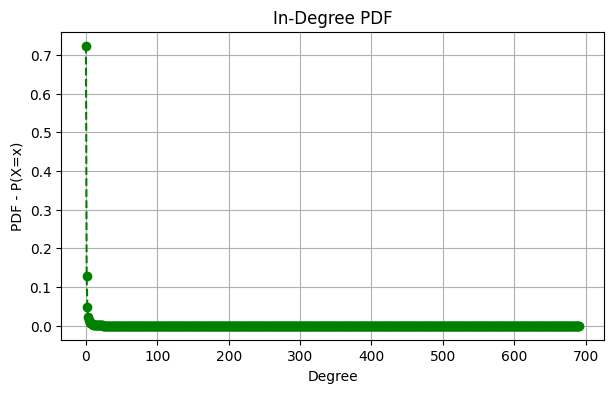

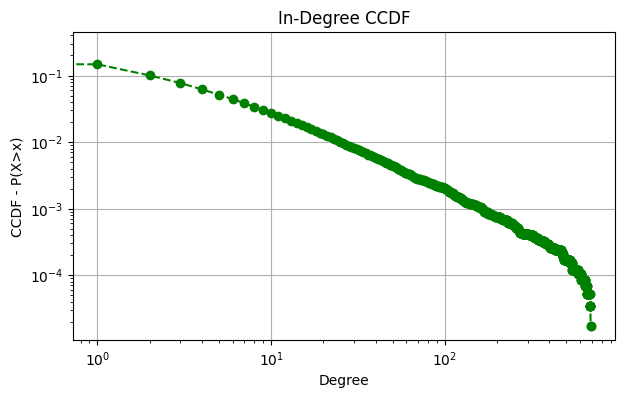

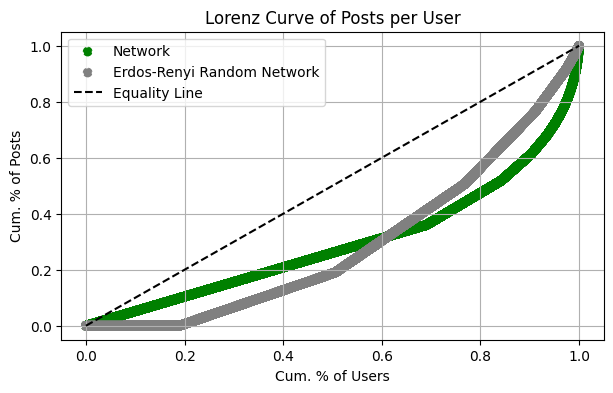

Gini Coefficient: 0.40516


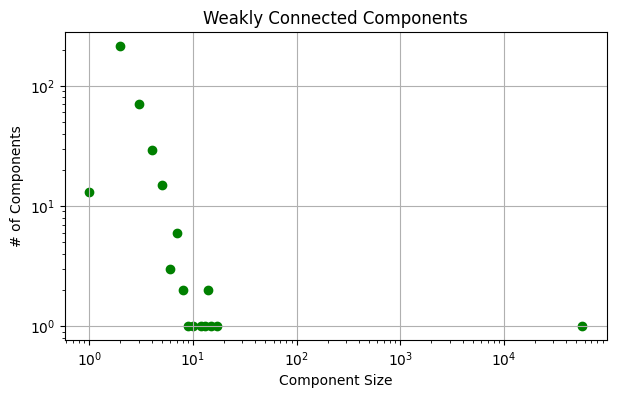

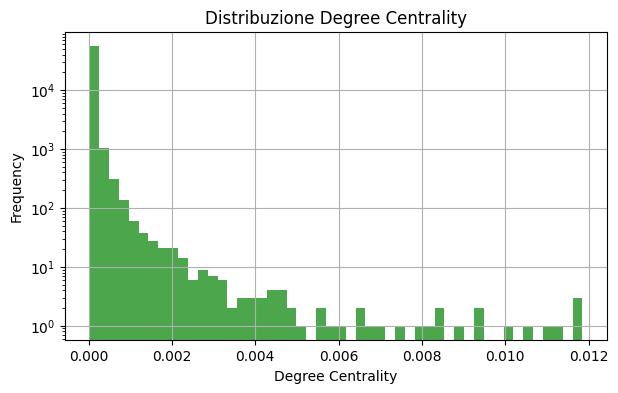

In [4]:
analyze_graph(Youtube_Graph, color="green")

In [5]:
yt_threads = youtube_db.get_threads()


thread_sizes = sorted([t.get_size() for t in yt_threads], reverse=True)
thread_unique_users = sorted([t.get_unique_users() for t in yt_threads], reverse=True)
thread_depths = sorted([t.get_depth() for t in yt_threads], reverse=True)
thread_wieners = sorted([t.get_wiener_index() for t in yt_threads], reverse=True)
thread_cpu = sorted([t.get_comments_per_user() for t in yt_threads], reverse=True)

print(len(yt_threads))
print(thread_sizes[:10])
print(thread_unique_users[:10])
print(thread_depths[:10])
print(thread_wieners[:10])
print(thread_cpu[:10])


# for thread in yt_threads[5:6]:
#     #YTThreadTree.print(thread)
#     print(thread.get_size())
#     print(thread.get_unique_users())
#     print(thread.get_depth())
#     print(thread.get_wiener_index())
#     print(thread.get_normalized_wiener_index())
#     print("------")
#     thread.print()

7200
[787, 777, 777, 762, 757, 755, 754, 754, 753, 753]
[731, 715, 697, 690, 660, 660, 614, 613, 611, 603]
[36, 29, 27, 25, 25, 21, 21, 19, 19, 18]
[1432108.0, 1352822.0, 1237826.0, 1224816.0, 1202126.0, 1076329.0, 1070698.0, 973331.0, 952244.0, 950082.0]
[8.0, 7.0, 4.75, 4.0, 4.0, 3.888888888888889, 3.75, 3.4705882352941178, 3.3333333333333335, 3.0]


In [6]:
print(len([d for d in thread_depths if d == 1]))
print(len([u for u in thread_unique_users if u == 1]))

3401
3415


In [6]:
best_threads = sorted(yt_threads, key=lambda t: t.get_comments_per_user(), reverse=True)[:10]

best_threads[3].print()

- @saeedbiamani2513: '28:56 is my favourite part I can’t stop watching that part it’s hilarious'
  - @donsolos: '😂😂😂😂😂😂😂😂😂\n\nI just made a comment about that too. That ish had me howling!! I pro'
  - @saeedbiamani2513: '@ next she’s gona say she started bloods&crips'
    - @donsolos: '@@saeedbiamani2513 nah she gonna drop a video with the homies showing off her c '
    - @donsolos: '@@saeedbiamani2513 I expect a video any day now to drop of her c walking'
    - @donsolos: '@@saeedbiamani2513 of course youtube deleted my reply to you'
      - @saeedbiamani2513: '@@donsolos 😂😂😂😂😂'
        - @donsolos: "@@saeedbiamani2513 is that your real name? That's a sick name"


In [38]:
import community as community_louvain

partition = community_louvain.best_partition(
    Youtube_Graph.to_undirected(),
    resolution=0.4
)

nx.set_node_attributes(Youtube_Graph, partition, 'community')

In [29]:
num_communities = len(set(partition.values()))

num_communities

439

In [39]:
nx.write_gexf(Youtube_Graph, "youtube.gexf")

In [6]:
from collections import defaultdict


# Define user stance

youtube_db.cursor.execute("""
SELECT Comments.id, author_id, label
FROM CommentAnalysis NATURAL JOIN Comments
""")
data = youtube_db.cursor.fetchall()
comments_author = {
    x[0]: x[1]
    for x in data
}

comments_stance = {
    x[0]: x[2]
    for x in data
}

user_comments_stance = defaultdict(list)
for comment, author in comments_author.items():
    user_comments_stance[author].append(comments_stance[comment])

user_stance = {
    user: np.average(comments_stance)
    for user, comments_stance in user_comments_stance.items()
}


In [7]:
def is_user_republican(account_id : str) -> bool:
    return user_stance.get(account_id, 0) > 0

def is_user_democratic(account_id : str) -> bool:
    return user_stance.get(account_id, 0) < 0


In [8]:
authors = set(comments_author.values())

d = 0
r = 0
n = 0

for author in authors:
    if is_user_republican(author):
        r+=1
    elif is_user_democratic(author):
        d+=1
    else:
        n+=1


print(f"Republican: {r}, Democratic: {d}, Neutral: {n}")

Republican: 26219, Democratic: 7805, Neutral: 27127


In [9]:

yt_threads = youtube_db.get_threads()

print(f"Youtube Threads: {len(yt_threads)}")

rep_threads = list()
dem_threads = list()
neutral_threads = list()

trump_threads = list()
harris_threads = list()

for thread in yt_threads:
    if is_user_republican(thread.value.author.id):
        rep_threads.append(thread)
    elif is_user_democratic(thread.value.author.id):
        dem_threads.append(thread)
    else:
        neutral_threads.append(thread)

    if thread.value.video_id in trump_podcasts:
        trump_threads.append(thread)
    else:
        harris_threads.append(thread)

trump_dem_threads = [thread for thread in trump_threads if thread in dem_threads]
trump_rep_threads = [thread for thread in trump_threads if thread in rep_threads]
harris_rep_threads = [thread for thread in harris_threads if thread in rep_threads]
harris_dem_threads = [thread for thread in harris_threads if thread in dem_threads]


print(f"Republican: {len(rep_threads)}, Democratic: {len(dem_threads)}, Neutral: {len(neutral_threads)}")
print(f"Trump: {len(trump_threads)}, Harris: {len(harris_threads)}")
print(f"Rep under Trump: {len(trump_rep_threads)}, Dem under Harris: {len(harris_dem_threads)}")
print(f"Dem under Trump: {len(trump_dem_threads)}, Rep under Harris: {len(harris_rep_threads)}")


Youtube Threads: 7200
Republican: 4191, Democratic: 830, Neutral: 2179
Trump: 5200, Harris: 2000
Rep under Trump: 3160, Dem under Harris: 241
Dem under Trump: 589, Rep under Harris: 1031


In [10]:
rep_thread_sizes = sorted([t.get_size() for t in rep_threads], reverse=True)
rep_thread_unique_users = sorted([t.get_unique_users() for t in rep_threads], reverse=True)
rep_thread_depths = sorted([t.get_depth() for t in rep_threads], reverse=True)
rep_thread_wieners = sorted([t.get_wiener_index() for t in rep_threads], reverse=True)
rep_thread_cpu = sorted([t.get_comments_per_user() for t in rep_threads], reverse=True)

dem_thread_sizes = sorted([t.get_size() for t in dem_threads], reverse=True)
dem_thread_unique_users = sorted([t.get_unique_users() for t in dem_threads], reverse=True)
dem_thread_depths = sorted([t.get_depth() for t in dem_threads], reverse=True)
dem_thread_wieners = sorted([t.get_wiener_index() for t in dem_threads], reverse=True)
dem_thread_cpu = sorted([t.get_comments_per_user() for t in dem_threads], reverse=True)

trump_thread_sizes = sorted([t.get_size() for t in trump_threads], reverse=True)
trump_thread_unique_users = sorted([t.get_unique_users() for t in trump_threads], reverse=True)
trump_thread_depths = sorted([t.get_depth() for t in trump_threads], reverse=True)
trump_thread_wieners = sorted([t.get_wiener_index() for t in trump_threads], reverse=True)
trump_thread_cpu = sorted([t.get_comments_per_user() for t in trump_threads], reverse=True)

harris_thread_sizes = sorted([t.get_size() for t in harris_threads], reverse=True)
harris_thread_unique_users = sorted([t.get_unique_users() for t in harris_threads], reverse=True)
harris_thread_depths = sorted([t.get_depth() for t in harris_threads], reverse=True)
harris_thread_wieners = sorted([t.get_wiener_index() for t in harris_threads], reverse=True)
harris_thread_cpu = sorted([t.get_comments_per_user() for t in harris_threads], reverse=True)

trump_dem_thread_sizes = sorted([t.get_size() for t in trump_dem_threads], reverse=True)
trump_dem_thread_unique_users = sorted([t.get_unique_users() for t in trump_dem_threads], reverse=True)
trump_dem_thread_depths = sorted([t.get_depth() for t in trump_dem_threads], reverse=True)
trump_dem_thread_wieners = sorted([t.get_wiener_index() for t in trump_dem_threads], reverse=True)
trump_dem_thread_cpu = sorted([t.get_comments_per_user() for t in trump_dem_threads], reverse=True)

trump_rep_thread_sizes = sorted([t.get_size() for t in trump_rep_threads], reverse=True)
trump_rep_thread_unique_users = sorted([t.get_unique_users() for t in trump_rep_threads], reverse=True)
trump_rep_thread_depths = sorted([t.get_depth() for t in trump_rep_threads], reverse=True)
trump_rep_thread_wieners = sorted([t.get_wiener_index() for t in trump_rep_threads], reverse=True)
trump_rep_thread_cpu = sorted([t.get_comments_per_user() for t in trump_rep_threads], reverse=True)

harris_dem_thread_sizes = sorted([t.get_size() for t in harris_dem_threads], reverse=True)
harris_dem_thread_unique_users = sorted([t.get_unique_users() for t in harris_dem_threads], reverse=True)
harris_dem_thread_depths = sorted([t.get_depth() for t in harris_dem_threads], reverse=True)
harris_dem_thread_wieners = sorted([t.get_wiener_index() for t in harris_dem_threads], reverse=True)
harris_dem_thread_cpu = sorted([t.get_comments_per_user() for t in harris_dem_threads], reverse=True)

harris_rep_thread_sizes = sorted([t.get_size() for t in harris_rep_threads], reverse=True)
harris_rep_thread_unique_users = sorted([t.get_unique_users() for t in harris_rep_threads], reverse=True)
harris_rep_thread_depths = sorted([t.get_depth() for t in harris_rep_threads], reverse=True)
harris_rep_thread_wieners = sorted([t.get_wiener_index() for t in harris_rep_threads], reverse=True)
harris_rep_thread_cpu = sorted([t.get_comments_per_user() for t in harris_rep_threads], reverse=True)

In [11]:
def plot_pdf_ccdf(
        list1,
        list2,
        title='PDF & CCDF',
        label1='List 1',
        label2='List 2',
        bins=50,
        loglog=True
):
    """
    Plot the PDF and CCDF of two datasets.

    Args:
        list1 (list): First dataset.
        list2 (list): Second dataset.
        bins (int): Number of bins for the histogram.
        loglog (bool): If True, plots log-log scale.
    """
    datasets = [list1, list2]
    labels = [label1, label2]
    colors = ['blue', 'orange']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # --- PDF (Histogram)
    for data, label, color in zip(datasets, labels, colors):
        counts, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        axs[0].plot(bin_centers, counts, marker='o', linestyle='-', label=label, color=color)

    axs[0].set_title(title)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    if loglog:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    # --- CCDF
    for data, label, color in zip(datasets, labels, colors):
        sorted_data = np.sort(data)
        ccdf = 1.0 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        axs[1].plot(sorted_data, ccdf, marker='o', linestyle='-', label=label, color=color)

    axs[1].set_title(title)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("CCDF")
    axs[1].legend()
    if loglog:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

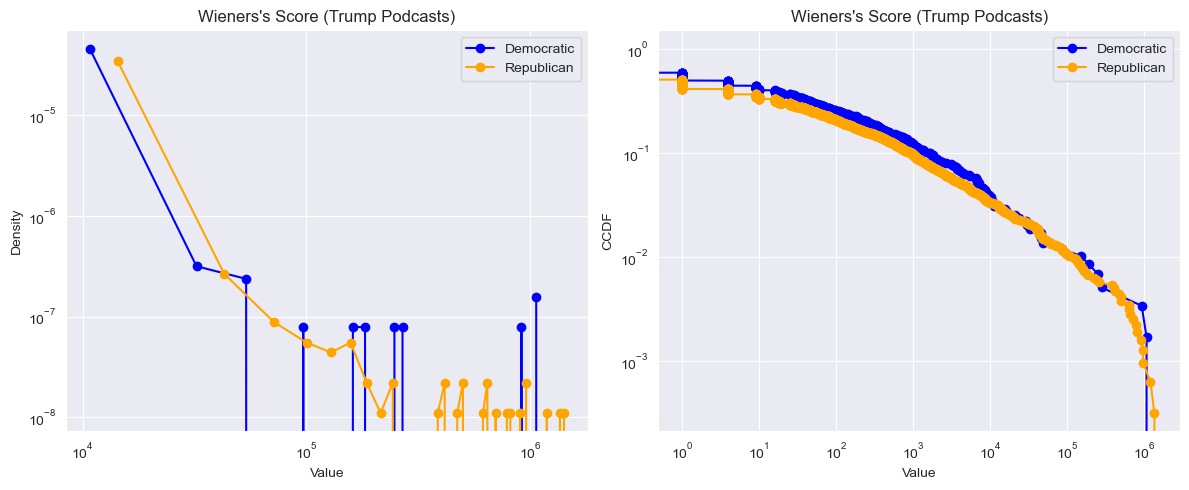

In [12]:
plot_pdf_ccdf(trump_dem_thread_wieners, trump_rep_thread_wieners, title="Wieners's Score (Trump Podcasts)", label1='Democratic', label2='Republican')

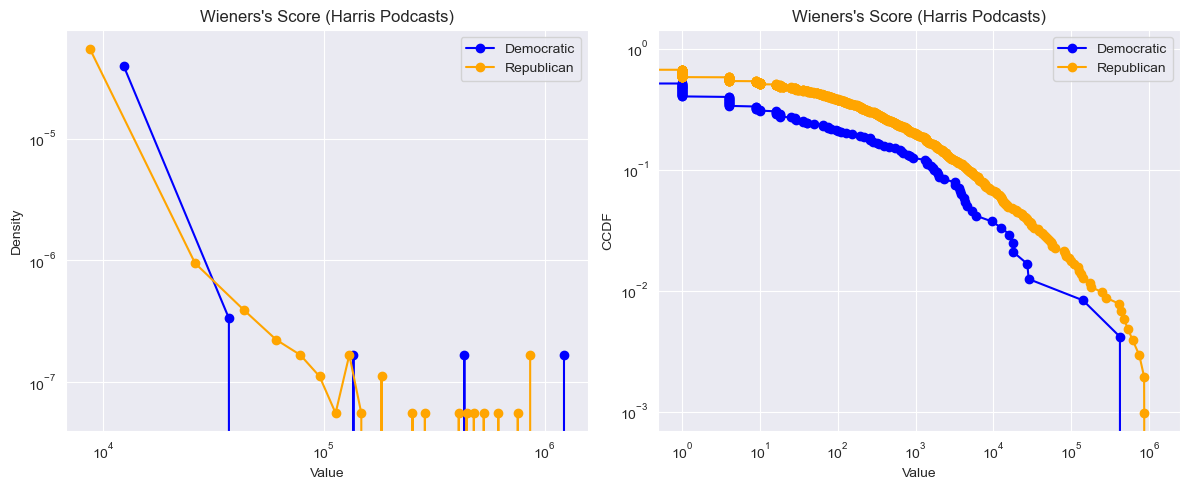

In [13]:
plot_pdf_ccdf(harris_dem_thread_wieners, harris_rep_thread_wieners, title="Wieners's Score (Harris Podcasts)", label1='Democratic', label2='Republican')

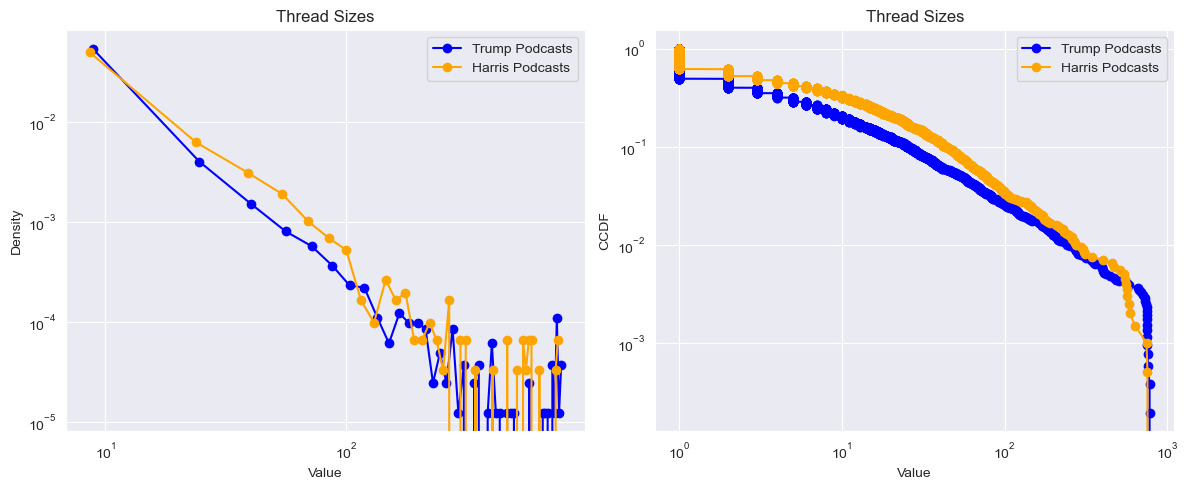

In [14]:
plot_pdf_ccdf(trump_thread_sizes, harris_thread_sizes, title="Thread Sizes", label1='Trump Podcasts', label2='Harris Podcasts')

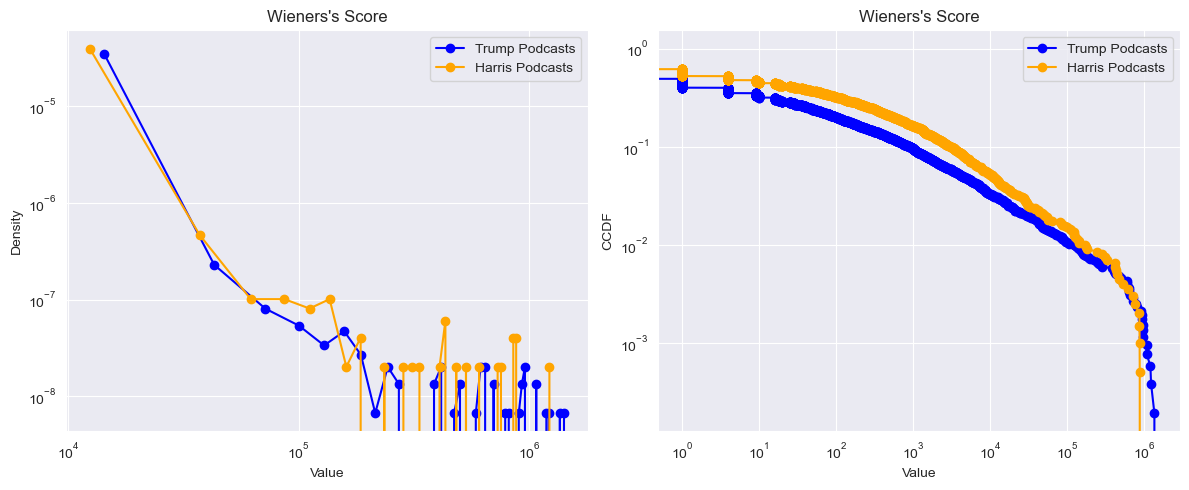

In [15]:
plot_pdf_ccdf(trump_thread_wieners, harris_thread_wieners, title="Wieners's Score", label1='Trump Podcasts', label2='Harris Podcasts')

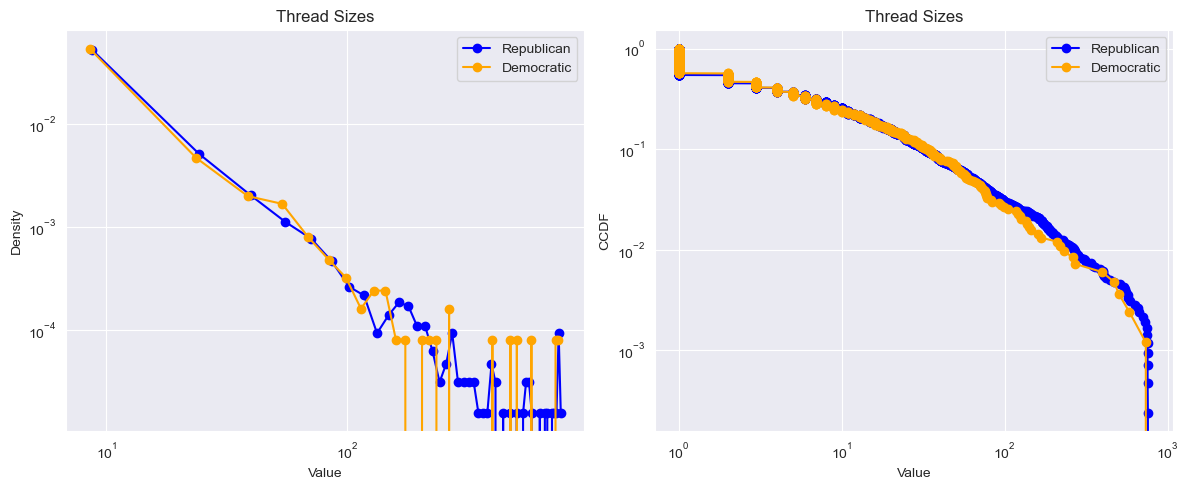

In [16]:
plot_pdf_ccdf(rep_thread_sizes, dem_thread_sizes, title="Thread Sizes", label1='Republican', label2='Democratic')

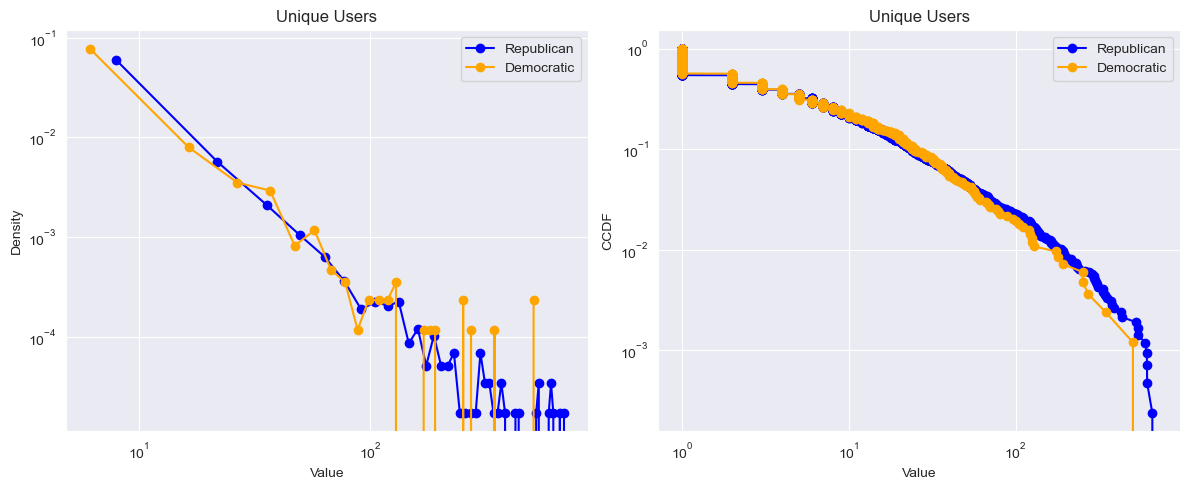

In [17]:
plot_pdf_ccdf(rep_thread_unique_users, dem_thread_unique_users, title="Unique Users", label1='Republican', label2='Democratic')

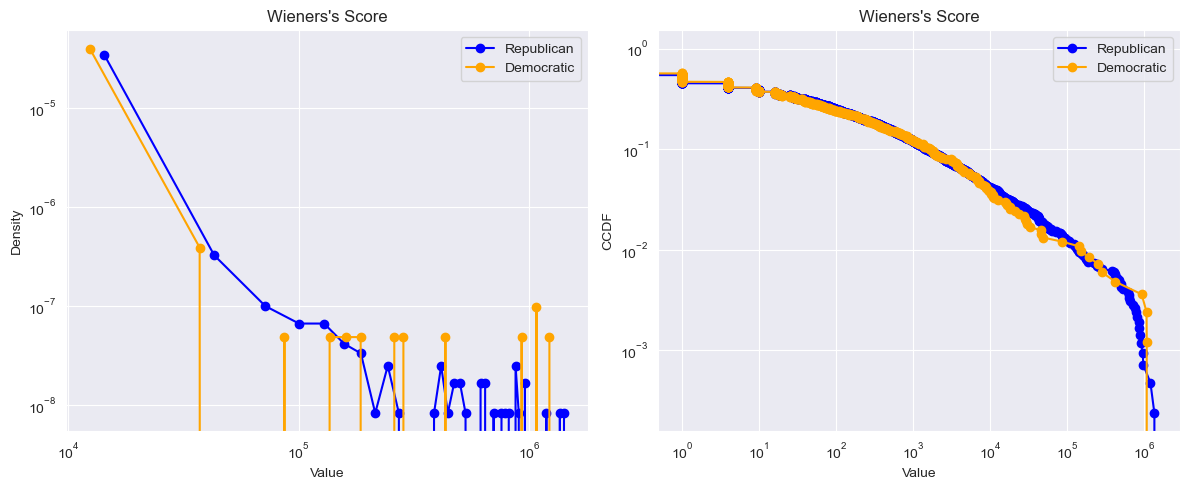

In [18]:
plot_pdf_ccdf(rep_thread_wieners, dem_thread_wieners, title="Wieners's Score", label1='Republican', label2='Democratic')

In [19]:
def is_cross_partisan(branch : list[youtube.YTComment]) -> bool:
    if not branch: return False
    stances = [user_stance.get(comment.author.id, 0) for comment in branch]
    return any(s > 0 for s in stances) and any(s < 0 for s in stances) # At least on > 0 and one < 0

In [20]:
all_branches = [
    branch
    for thread in yt_threads
    for branch in thread.get_branches()
]

cross_partisan_branches = [
    branch
    for branch in all_branches
    if is_cross_partisan(branch)
]

print(f"Cross Partisan: {len(cross_partisan_branches)} ({len(cross_partisan_branches)/len(all_branches)*100:.2f}%)")

Cross Partisan: 22657 (25.02%)


In [21]:
branch = cross_partisan_branches[164]
for comment in branch:
    print(f"{comment.author.display_name}: {comment.content} ({user_stance.get(comment.author.id)})")

@abnwa1974: MSNBC is saying Trump can’t finish a sentence 🤦🏽‍♀️ (1.0)
@poom641: It's OFTEN true, and i'm anti-Biden etc.  trump starts a thought then skates away from it like nancy kerrigan.
    I want to be pro - Trump but he  COMPLETELY avoided the 'net-yahoo' question at  27:36 (1.0)
@brendan6612: @@poom641He’s literally always done that. Do you think he’s showing signs of cognitive decline that would make him incapable to serve as president? (-0.5)
